<a href="https://colab.research.google.com/github/REnglert/Housing_Market/blob/master/CS6190_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Boston Housing Market**

CS6190 - Probablistic Modeling Final Project

Authors: Bruce Englert, Mario Magana-Garcia

In [0]:
""" Standard Library Imports """
import numpy as np
from numpy import linalg as NA

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

from scipy import stats
from scipy.special import expit #sigmoid - y

import pandas as pd

from PIL import Image, ImageDraw

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
""" Read in Data and Format It """
url = 'https://raw.githubusercontent.com/REnglert/Housing_Market/master/housing.data'
df = pd.read_csv(url,sep=",", names=
                 ["CRIM","ZN","INDUS","CHAS","NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


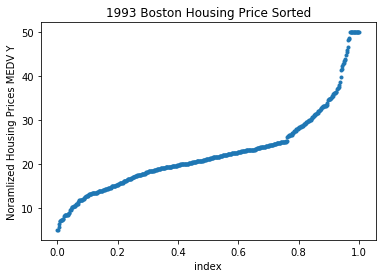

In [3]:
df = np.array(df) # convert to numpy array
""" Plot MEDV """
Y_medv = df[:,-1]
Y_medv.sort()
plt.scatter(np.linspace(start=0,stop=1,num= Y_medv.shape[0]) ,Y_medv, marker='.')
plt.title('1993 Boston Housing Price Sorted')
plt.xlabel('index')
plt.ylabel('Noramlized Housing Prices MEDV Y')
plt.show()

In [0]:
""" Now we define our own GMM implemented model """
def multi_norm(X, mu, cov):
    return stats.multivariate_normal.pdf(X, np.transpose(mu), cov).reshape(-1,1)

def GMM_train(X, iters):
  """
  Performs Gaussian Mixture on data to find clusters
  X             : is the data
  iters     : Max # of iterations
  """
  # Initializations of clusters
  N = X.shape[0]
  M = X.shape[1]
  k = 3
  scores = np.zeros((N, k))
  clusters = [] #set of clusters
  cov_i = 0.25 * np.identity(2) # Sets initial covariance
  pi_0 = 1.0 / k
  clusters.append({'pi_k': pi_0,'mu_k': [0, 0], 'cov_k': cov_i})
  clusters.append({'pi_k': pi_0,'mu_k': [0.50, 0.50], 'cov_k': cov_i})
  clusters.append({'pi_k': pi_0,'mu_k': [1, 1], 'cov_k': cov_i})

  # Perform GMM
  for i in range(iters):
    # E_step
    totals = np.zeros((N, 1))
    for cluster in clusters:
        pi_k = cluster['pi_k']; 
        mu_k = cluster['mu_k']; 
        cov_k = cluster['cov_k']; 
        y_nk = (pi_k * multi_norm(X, mu_k, cov_k));
                    
        totals += y_nk;        
        cluster['y_nk'] = y_nk; 
        cluster['totals'] = totals;  
        
    for cluster in clusters:
        cluster['y_nk'] /= cluster['totals']  
       
    # M_step
    for cluster in clusters:
        y_nk = cluster['y_nk']
        cov_k = np.zeros((M, M))      
        N_k = np.sum(y_nk)     
        pi_k = N_k / N
        mu_k = np.sum(y_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1,1)
            cov_k += y_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        cluster['pi_k'] = pi_k; 
        cluster['mu_k'] = mu_k; 
        cluster['cov_k'] = cov_k

  # ================== Graph Results ==================
  fig, ax = plt.subplots(1, 1)
  colorset = ['blue', 'red','green'] 
  idx = 0

  for i, cluster in enumerate(clusters):
      scores[:, i] = np.log(cluster['y_nk']).reshape(-1)

  for i in range(X.shape[0]):
      ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='.')
      #print(i)
      #print(colorset[np.argmax(scores[i])])

  # Through exploration of above data, we found the housing clustering boundaries
  plt.plot([0,1], [X[142,1],X[142,1]])  
  plt.plot([0,1], [X[384,1],X[384,1]])
  print('index change 142')
  print(X[142,1])
  print('index change 384')
  print(X[384,1])

  for cluster in clusters:
      mu = cluster['mu_k']
      cov = cluster['cov_k']
      print('Cluster center(mean) = ')
      print(mu)
      print('Cluster covariance = ')
      print(cov)

      eigenvalues, eigenvectors = np.linalg.eigh(cov)
      order = eigenvalues.argsort()[::-1]
      eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
      vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
      theta = np.arctan2(vy, vx)
      color = colors.to_rgba(colorset[idx])
      for cov_factor in range(1, 4):
          ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
          ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
          ax.add_artist(ell)

      plt.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
      idx += 1

  plt.title('1993 Boston Housing Price Clusters')
  plt.xlabel('index')
  plt.ylabel('Noramlized Housing Prices MEDV Y')
  plt.show()

# Now we can look at how our normalized housing prices can be looked at with a clustering algorithm so gain an idea of the different levels of housing price tiers (lower, middle, upper) based on our clusters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


index change 142
0.28444444444444444
index change 384
0.45111111111111113
Cluster center(mean) = 
[0.52267432 0.36768997]
Cluster covariance = 
[[0.01884862 0.00622583]
 [0.00622583 0.0020598 ]]
Cluster center(mean) = 
[0.14230041 0.18440526]
Cluster covariance = 
[[0.00687519 0.00567118]
 [0.00567118 0.00497871]]
Cluster center(mean) = 
[0.88057694 0.67687313]
Cluster covariance = 
[[0.00483834 0.01142152]
 [0.01142152 0.0299761 ]]


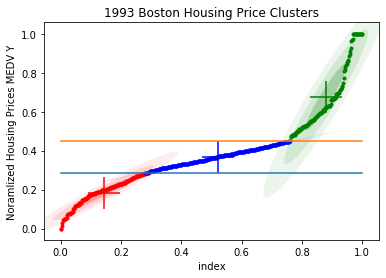

In [5]:
""" Perform GMM on data """
""" Normalize data from 0 to 1, and sort medv (lowest to highest) """
Y_gmm = df[:,-1] #prices
y_min = np.min(Y_gmm); y_max = np.max(Y_gmm);
for i in range(0, np.size(Y_gmm)):
    Y_gmm[i] = (Y_gmm[i] - y_min) / (y_max - y_min)
Y_gmm.sort()
#print(Y)
data_gmm = np.array([np.linspace(start=0,stop=1,num= Y_gmm.shape[0]).ravel(), Y_gmm]).T

GMM_train(data_gmm, 20);

Using the results from the GMM clustering algorithm, we can assign labels to specific sets of data: 0 (lower), 1 (middle), 2(upper) for a multi-class logistic regression

In [0]:
""" Assign labels based on housing tier classification """
""" For learning algorithms, labels: 0 (lower), 1 (middle), 2(upper) """
tier_12_cut = 0.285 * (y_max - y_min) + y_min;
tier_23_cut = 0.452 * (y_max - y_min) + y_min;
#print(tier_12_cut)
#print(tier_23_cut)

""" verification """
#Y_medv = Y_medv * (y_max - y_min) + y_min
#plt.scatter(np.linspace(start=0,stop=1,num=Y_medv.shape[0]), Y_medv, marker='.')
#plt.plot([0,1], [tier_12_cut,tier_12_cut])  # Through exploration of above data, we found the housing clustering boundaries
#plt.plot([0,1], [tier_23_cut,tier_23_cut])

""" Y_labels for multi-class regression """
df = pd.read_csv(url,sep=",", names=["CRIM","ZN","INDUS","CHAS","NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])
df = np.array(df)
Y_labels = df[:,-1]

for i in range(len(Y_labels)):
  if Y_labels[i] <= tier_12_cut:
    Y_labels[i] = 0
  elif Y_labels[i] <= tier_23_cut:
    Y_labels[i] = 1
  else:
    Y_labels[i] = 2

""" Get Y_labels_3 (dirty method) by splitting multi-class target label into seperate labels """
""" lower or not, middle or not, upper or not """
""" when targetting a specific label, just extract that column vector """
Y_labels_3 = np.zeros([len(Y_labels), 3])
#print(Y_labels_3.shape)
for i in range(len(Y_labels)):
  if Y_labels[i] == 0:
    Y_labels_3[i,0] = 1
  elif Y_labels[i] == 1:
    Y_labels_3[i,1] = 1
  else:
    Y_labels_3[i,2] = 1

#print(Y_labels_3)

In [0]:
""" Format/Normalize Data """
from sklearn.preprocessing import normalize

X_normed = normalize(df[:,:-1], axis=1, norm='l2') #grab all parameters except target label

SkLean Methods on our dataset Logistic Regression & Linear Regression

In [8]:
""" sklearn Logistic Regression """
"""Split data: %33 test"""
X_train,X_test,Y_train,Y_test=train_test_split(X_normed,Y_labels,test_size=0.33,random_state=0)
logR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter = 5000)
"""Fit"""
logR.fit(X_train, Y_train)
"""Predict"""
Y_pred= logR.predict(X_test)
"""Score"""
score = logR.score(X_normed,Y_labels)
print("Mean Accuracy: ", score)

Mean Accuracy:  0.6047430830039525


Error:  26.558581842040596


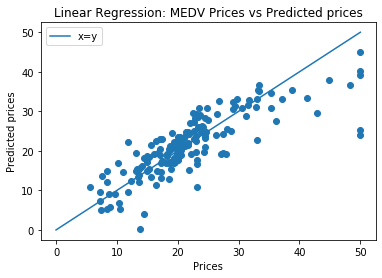

In [9]:
"""sklearn Linear Regression Model Looking at pricing """
"""Setup train and testing data"""
df = pd.read_csv(url,sep=",", names=
                 ["CRIM","ZN","INDUS","CHAS","NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])
Y = df['MEDV']
X = df.drop('MEDV', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 0)

"""Linear Regression"""
linR = LinearRegression()
linR.fit(X_train, Y_train)
Y_pred = linR.predict(X_test)

"""Plot scatter of data"""
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Linear Regression: MEDV Prices vs Predicted prices")

"""Evaluate Error"""
mse = sklearn.metrics.mean_squared_error(Y_test, Y_pred)
print("Error: ", mse)

plt.plot([0,50],[0,50],label='x=y')
plt.legend()
plt.show()

Split Data for our logistic regression methods


In [0]:
""" Logistic Regression with Raphson-Newton updates """
def raphson_newton_log_reg_train(X_train, Y_train, label):
  # Initialize params
  m,n = np.shape(X_train)
  X0 = np.ones((m,1))
  Phi = np.hstack((X0,X_train))

  W = np.zeros((n+1,1)) 
  maxIters = 10
  tol = 1e-6

  ilist = []
  errlist = []

  for i in range(0,maxIters):
      y = expit(Phi @ W)
      R = np.identity(m) * y * (1 - y)
      Z = Phi @ W - NA.inv(R) @ (y - Y_train)
      
      W_new = NA.inv(Phi.T @ R @ Phi) @ Phi.T @ R @ Z
      
      err = NA.norm(W_new - W)
      W = W_new

      ilist.append(i)
      errlist.append(err)
      
  plt.plot(ilist,errlist, label=label)
  plt.title('Logistic Regression Raphsen-Newton : Error')
  plt.xlabel('iterations i')
  plt.ylabel('Error norm')
  return W

In [0]:
""" Perform logistic regression models to find weights, parameters, convergence, and accuracy """
m = 355
n = 13
X_data = X_normed[:m,:n]
t_label0 = Y_labels_3[:m,0].reshape(m,1)
t_label1 = Y_labels_3[:m,1].reshape(m,1)
t_label2 = Y_labels_3[:m,2].reshape(m,1)

# Get test data to check accuracy of weights
t_test0 = Y_labels_3[m:,0].reshape(-1)
t_test1 = Y_labels_3[m:,1].reshape(-1)
t_test2 = Y_labels_3[m:,2].reshape(-1)

X_test = X_normed[m:,:]
X0 = np.ones((X_test.shape[0],1))
X_test = np.hstack((X0,X_test))

Lower Weights = [[  -27.92576808]
 [  424.36222075]
 [  -33.12757889]
 [    6.97077792]
 [ -526.86894259]
 [ 4328.423189  ]
 [-1532.77558443]
 [   33.0006383 ]
 [  714.14222613]
 [ -553.66327993]
 [   25.10911746]
 [  169.84508699]
 [    9.54685665]
 [  136.73688241]]
Middle Weights = [[   34.8048877 ]
 [ -464.80728736]
 [  -11.09300053]
 [   38.61409603]
 [   61.27806023]
 [  332.21923501]
 [-1191.52961466]
 [   -4.17773944]
 [  146.32454771]
 [   79.2847276 ]
 [  -18.26282177]
 [   67.45182281]
 [  -14.22647468]
 [  -76.3823723 ]]
Upper Weights = [[ 2.55891441e+00]
 [ 5.76522201e+01]
 [-7.10419394e-01]
 [-3.23898424e+01]
 [ 3.52988449e+02]
 [-6.88447136e+03]
 [ 2.34476206e+03]
 [-2.80838570e+00]
 [-3.17263925e+02]
 [ 6.66177529e+01]
 [-1.05477912e+01]
 [-2.82018574e+02]
 [-7.95454572e+00]
 [-1.09534734e+02]]
Accuracy for test data lower t_0 :
0.5033112582781457
Accuracy for test data middle t_1 :
0.5761589403973509
Accuracy for test data upper t_2 :
0.9139072847682119


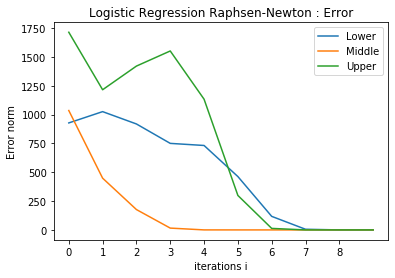

In [12]:
# perform log regression
weights0 = raphson_newton_log_reg_train(X_data,t_label0, 'Lower')
print("Lower Weights = " + str(weights0))
weights1 = raphson_newton_log_reg_train(X_data,t_label1, 'Middle')
print("Middle Weights = " + str(weights1))
weights2 = raphson_newton_log_reg_train(X_data,t_label2, 'Upper')
print("Upper Weights = " + str(weights2))
plt.legend()
plt.xticks([0,1, 2, 3, 4, 5,6,7,8])

# check accuracy
preds = np.round(expit(X_test @ weights0))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test0[i]):
    count += 1
print('Accuracy for test data lower t_0 :'); print(count / len(preds));
 
preds = np.round(expit(X_test @ weights1))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test1[i]):
    count += 1
print('Accuracy for test data middle t_1 :'); print(count / len(preds));

preds = np.round(expit(X_test @ weights2))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test2[i]):
    count += 1
print('Accuracy for test data upper t_2 :'); print(count / len(preds));

In [0]:
""" Logistic Regression with Variational Inference EM style updates """
def variational_log_reg_train(X_train, Y_train, label):
  # Initializations
  m,n = X_train.shape
  Phi = np.append(X_train, np.ones([m,1]),1) #add intercept
  s_0 = np.eye(n+1)
  x_i = np.random.uniform(-1,1, size=m)
  max_iters = 6
  tol = 1e-5

  ilist = []
  errlist = []

  # Train Model
  for i in range(max_iters):
      lambda_ = (expit(x_i) - 1/2) / (2 * x_i)
      s_n = NA.inv(NA.inv(s_0) + 2 * (lambda_ * Phi.T).dot(Phi))       
      m_n = s_n.dot(np.sum(Phi.T @ (Y_train - 1/2), axis=1))       
      x_i_New = np.sqrt(np.sum(Phi.dot(s_n + m_n * m_n.T[:, None]) * Phi, axis=1)) 
     
      err = NA.norm(x_i_New - x_i)
      x_i = x_i_New

      ilist.append(i)
      errlist.append(err)

  plt.plot(ilist,errlist,label=label)
  plt.title('Variational Logistic Regression: Error')
  plt.xlabel('iterations i')
  plt.ylabel('Error norm')
  return m_n

[ 5.29408304e-02 -1.01295328e+00  3.63946746e-01 -9.14365246e-04
  6.65423873e-03 -7.01323870e-02  1.94854877e+00 -6.25866816e-02
 -5.29772015e-02  1.27208934e+00  4.42958097e-02 -2.64508121e+00
  7.68344317e-01 -8.22058359e-01]
[-0.04075012 -1.26345589  0.1680747  -0.00686472 -0.00599092 -0.1227253
 -1.19036324  0.06629628 -0.00806323  0.46906296  0.12786437  0.25078878
  0.09829921 -0.13750519]
[-0.0127923   2.05631547 -0.54289941  0.00729447 -0.00240351  0.16584517
 -0.75628169 -0.02839492  0.05116766 -2.25667867 -0.2356836   1.33739294
 -0.87296843 -0.37586769]
Accuracy for test data lower t_0 :
0.6225165562913907
Accuracy for test data middle t_1 :
0.31788079470198677
Accuracy for test data upper t_2 :
0.9403973509933775


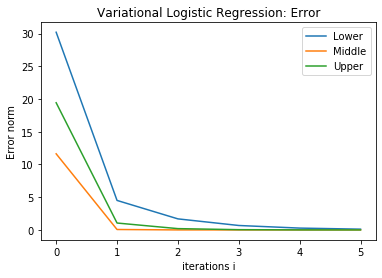

In [14]:
weights0 = variational_log_reg_train(X_data,t_label0, 'Lower')
print(weights0)
weights1 = variational_log_reg_train(X_data,t_label1, 'Middle')
print(weights1)
weights2 = variational_log_reg_train(X_data,t_label2, 'Upper')
print(weights2)
plt.legend()
plt.xticks([0,1, 2, 3, 4, 5])

# check accuracy
preds = np.round(expit(X_test @ weights0))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test0[i]):
    count += 1
print('Accuracy for test data lower t_0 :'); print(count / len(preds));
 
preds = np.round(expit(X_test @ weights1))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test1[i]):
    count += 1
print('Accuracy for test data middle t_1 :'); print(count / len(preds));

preds = np.round(expit(X_test @ weights2))
count = 0
for i in range(len(preds)):
  if(preds[i] == t_test2[i]):
    count += 1
print('Accuracy for test data upper t_2 :'); print(count / len(preds));